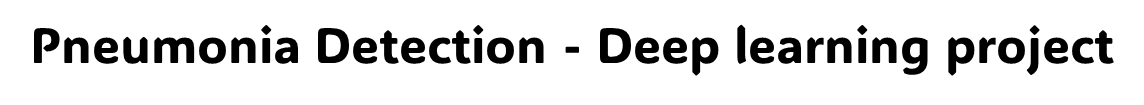

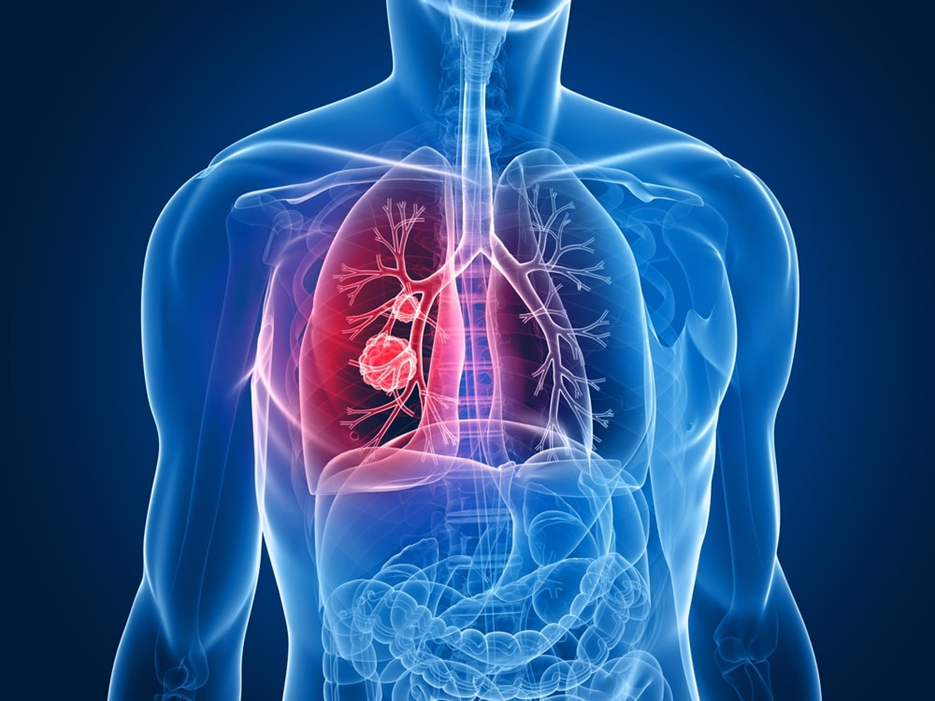

Pneumonia is an infection that inflames the air sacs in one or both lungs. <br/>It kills more children younger than 5 years old each year than any other infectious disease, such as HIV infection, malaria, or tuberculosis. Diagnosis is often based on symptoms and physical examination. <br/>Chest X-rays may help confirm the diagnosis.



---



In [1]:
!python --version

Python 3.10.12


In [2]:
import torch
torch.__version__

'2.1.0+cu121'

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import os

import numpy as np
from matplotlib import pyplot as plt

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

<br>
<br>
<hr class="dashed">
<br>
<br>

###**Establishing connection between "Colab" to "Google Drive"**

In [5]:
# Code for connecting our google drive to this collab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Check what files we have in the path
!ls "/content/drive/MyDrive/My Projects/deep learning"

classification_resnet18.ipynb  dataset	DL_project.ipynb




---



In [7]:
import os
from torchvision import datasets, transforms

data_dir = '/content/drive/MyDrive/My Projects/deep learning/dataset'

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train',  'test']}

We have a directory (data_dir) with two subdirectories: 'train' and 'test', each containing images related to lung cancer.

Using transforms. Compose allows us to apply a sequence of transformations to the images. In this case, it resizes, crops, converts to a PyTorch tensor, and normalizes the pixel values.

</h1> *******</h1>

Now that we have our datasets, we want to load them in batches for training and validation using torch.utils.data.DataLoader.

* **batch_size=4**: This means we will process four images at a time during training.

* **shuffle=True**: Shuffling the data ensures that the model doesn't learn patterns based on the order of images.

* **num_workers=2**: This parameter allows we to load data in parallel using two worker processes.

* **dataset_sizes**: It gives us the number of images in the 'train' and 'val' sets.

* **class_names**: This provides the classes or categories in ours dataset, which are 'NORMAL' and 'PNEUMONIA' in this case.

In [8]:
import torch

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=4,
        shuffle=True,
        num_workers=2
    ) for x in ['train', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

{'train': 5232, 'test': 624}
['NORMAL', 'PNEUMONIA']


**Visualization of a sample of images**

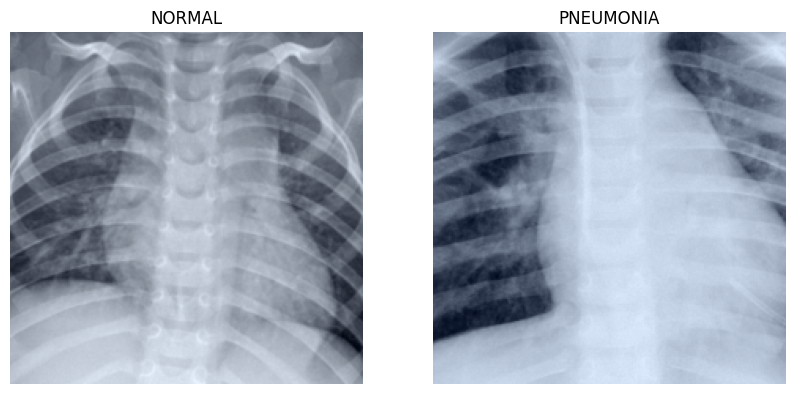

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np

labels_for_viz = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
classes_to_visualize = ['NORMAL', 'PNEUMONIA']
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()

for i, class_label in enumerate(classes_to_visualize):
    class_idx = [key for key, value in labels_for_viz.items() if value == class_label][0]
    class_indices = [idx for idx, label in enumerate(image_datasets['train'].targets) if label == class_idx]
    sample_idx = random.choice(class_indices)
    sample_image, sample_label = image_datasets['train'][sample_idx]
    sample_image = sample_image.numpy().transpose((1, 2, 0))
    sample_image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())
    ax[i].imshow(sample_image)
    ax[i].set_title(class_label)
    ax[i].axis('off')

plt.show()

In [11]:
import torch
import torchvision.models as models

# Load a pre-trained ResNet-18 model with ImageNet weights
model = models.resnet18(pretrained=True)

# Freeze all layers except the fully connected (fc) layer for transfer learning
for name, param in model.named_parameters():
    param.requires_grad = "fc" in name

# Define CrossEntropyLoss for multi-class classification
criterion = torch.nn.CrossEntropyLoss()

# Set up Stochastic Gradient Descent (SGD) optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Determine device availability and move the model accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [12]:
import torch

num_epochs = 10

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(1, num_epochs + 1):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # Save values to respective history lists
        if phase == 'train':
            train_loss_history.append((epoch, epoch_loss))
            train_accuracy_history.append((epoch, epoch_acc))
        else:
            test_loss_history.append((epoch, epoch_loss))
            test_accuracy_history.append((epoch, epoch_acc))

        print(f'Completed Epoch: {epoch} - {phase.capitalize()} Accuracy: {epoch_acc*100:.0f}% - {phase.capitalize()} Loss: {epoch_loss:.4f}')

print("Training complete!")

Completed Epoch: 1 - Train Accuracy: 85% - Train Loss: 0.4125
Completed Epoch: 1 - Test Accuracy: 82% - Test Loss: 0.5352
Completed Epoch: 2 - Train Accuracy: 89% - Train Loss: 0.2922
Completed Epoch: 2 - Test Accuracy: 93% - Test Loss: 0.1963
Completed Epoch: 3 - Train Accuracy: 89% - Train Loss: 0.2829
Completed Epoch: 3 - Test Accuracy: 78% - Test Loss: 0.7161
Completed Epoch: 4 - Train Accuracy: 89% - Train Loss: 0.2992
Completed Epoch: 4 - Test Accuracy: 92% - Test Loss: 0.2494
Completed Epoch: 5 - Train Accuracy: 90% - Train Loss: 0.2587
Completed Epoch: 5 - Test Accuracy: 88% - Test Loss: 0.3409
Completed Epoch: 6 - Train Accuracy: 91% - Train Loss: 0.2588
Completed Epoch: 6 - Test Accuracy: 75% - Test Loss: 0.8566
Completed Epoch: 7 - Train Accuracy: 89% - Train Loss: 0.3226
Completed Epoch: 7 - Test Accuracy: 92% - Test Loss: 0.2353
Completed Epoch: 8 - Train Accuracy: 90% - Train Loss: 0.2828
Completed Epoch: 8 - Test Accuracy: 91% - Test Loss: 0.2395
Completed Epoch: 9 - Tra

The code represents a training loop for a machine-learning model using the PyTorch framework. The primary goal is to iteratively update the model's parameters to minimize a defined loss function, making the model perform well on a given dataset. The training process involves the following steps:

1. **Iterative Optimization**: The model is trained over a fixed number of epochs, during which it iteratively processes batches of training data. In each iteration, the model computes predictions, evaluates the loss, and adjusts its parameters to reduce the loss.

2. **Model Phases**: The training loop operates in two phases: 'train' and 'test'. During the 'train' phase, the model learns by updating its parameters, while in the 'test' phase, the model is evaluated on a separate dataset to assess its generalization performance.

3. **Gradient Descent Optimization**: The optimization algorithm (e.g., stochastic gradient descent) is used to adjust the model's parameters based on the computed gradients of the loss with respect to those parameters. This process aims to find the optimal set of parameters that minimizes the discrepancy between the model's predictions and the true labels.

4. **Loss Computation and Backpropagation**: The loss is calculated as a measure of the model's performance, representing the difference between predicted and true values. During the 'train' phase, backpropagation is employed to propagate this loss backward through the model's layers, enabling the computation of gradients.

5. **Parameter Update**: The optimizer adjusts the model's parameters in the direction that reduces the loss, effectively fine-tuning the model to improve its predictions.

6. **Performance Monitoring**: Epoch-level metrics, such as accuracy and loss, are monitored and recorded for both training and testing phases. This information is valuable for understanding how well the model is learning from the data and generalizing to new, unseen examples.

7. **Training Completion**: The process repeats for the specified number of epochs, and once completed, the training loop prints a message indicating that the training is finished.

In summary, the code facilitates the training of a machine learning model, guiding it through a series of updates to its parameters to improve its ability to make accurate predictions on a given task. The recorded metrics serve as a measure of the model's performance and guide further analysis or model selection.

In [13]:
# Convert accuracy values to decimals between 0 and 1
train_accuracy_history = [(epoch, acc) for epoch, acc in train_accuracy_history]
test_accuracy_history = [(epoch, acc) for epoch, acc in test_accuracy_history]


print(train_accuracy_history)
print(test_accuracy_history)
print(train_loss_history)
print(test_loss_history)

[(1, tensor(0.8547, dtype=torch.float64)), (2, tensor(0.8880, dtype=torch.float64)), (3, tensor(0.8897, dtype=torch.float64)), (4, tensor(0.8926, dtype=torch.float64)), (5, tensor(0.9041, dtype=torch.float64)), (6, tensor(0.9073, dtype=torch.float64)), (7, tensor(0.8907, dtype=torch.float64)), (8, tensor(0.8962, dtype=torch.float64)), (9, tensor(0.9039, dtype=torch.float64)), (10, tensor(0.8964, dtype=torch.float64))]
[(1, tensor(0.8221, dtype=torch.float64)), (2, tensor(0.9279, dtype=torch.float64)), (3, tensor(0.7821, dtype=torch.float64)), (4, tensor(0.9167, dtype=torch.float64)), (5, tensor(0.8846, dtype=torch.float64)), (6, tensor(0.7532, dtype=torch.float64)), (7, tensor(0.9167, dtype=torch.float64)), (8, tensor(0.9135, dtype=torch.float64)), (9, tensor(0.8958, dtype=torch.float64)), (10, tensor(0.9215, dtype=torch.float64))]
[(1, 0.41253160907037306), (2, 0.29223735463393835), (3, 0.2829132584465752), (4, 0.29916101269887574), (5, 0.25871440591093453), (6, 0.2587703915678197), (

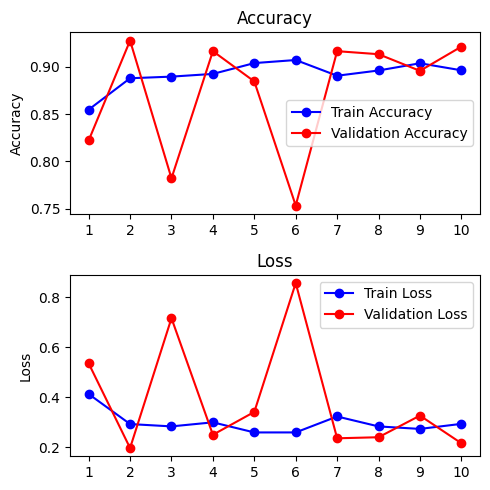

In [21]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(5, 5))

# Accuracy Plot
axs[0].plot(*zip(*train_accuracy_history), label='Train Accuracy', marker='o', linestyle='-', color='b')
axs[0].plot(*zip(*test_accuracy_history), label='Validation Accuracy', marker='o', linestyle='-', color='r')
axs[0].set_title('Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_xticks(range(1, 11))

# Loss Plot
axs[1].plot(*zip(*train_loss_history), label='Train Loss', marker='o', linestyle='-', color='b')
axs[1].plot(*zip(*test_loss_history), label='Validation Loss', marker='o', linestyle='-', color='r')
axs[1].set_title('Loss')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

**Training Accuracy:**
1. **Epoch-to-Epoch Improvement:** The training accuracy consistently improves from one epoch to the next, indicating that the model is learning and adapting to the training data.
2. **Final Accuracy:** The final training accuracy after 10 epochs is approximately 89.6%. This suggests that the model is performing well on the training data, correctly classifying the majority of examples.

**Testing Accuracy:**
1. **Epoch-to-Epoch Variation:** The testing accuracy shows some variation from epoch to epoch. This could be due to factors such as model overfitting, variations in the test dataset, or the model encountering different patterns in the test set.
2. **Generalization Performance:** The final testing accuracy after 10 epochs is approximately 92.2%. This indicates that the model generalizes well to unseen data, as it achieves high accuracy on examples not used during training.
3. **Comparative Analysis:** The testing accuracy is comparable to, and in some cases, higher than the training accuracy. This suggests that the model is not overfitting the training data and is able to generalize effectively.

**Conclusions:**
- The model demonstrates good learning capability on the training set, achieving an accuracy of approximately 89.6%.
- The ability to generalize is evident in the testing phase, where the model attains a final accuracy of around 92.2%, performing well on previously unseen examples.
- The consistency in performance improvement on both training and testing sets throughout the epochs is a positive sign, indicating stable learning dynamics.
- The testing accuracy surpassing the training accuracy suggests that the model is not overfitting and is indeed learning relevant patterns from the data.

In summary, the model appears to be well-trained and capable of making accurate predictions on new, unseen examples, as evidenced by the high testing accuracy. The training process seems effective, leading to a model that generalizes well to different data instances.

**Training Loss:**
1. **Epoch-to-Epoch Trend:** The training loss decreases consistently from one epoch to the next, indicating that the model is effectively minimizing its error on the training dataset.
2. **Final Training Loss:** The final training loss after 10 epochs is approximately 0.2931. This suggests that the model is fitting well to the training data, achieving a low level of error.

**Testing Loss:**
1. **Epoch-to-Epoch Variation:** The testing loss shows some fluctuation from epoch to epoch. This could be due to the model encountering different patterns in the test dataset or other factors such as variations in the test set.
2. **Generalization Performance:** The final testing loss after 10 epochs is approximately 0.2154. This indicates that the model generalizes well to unseen data, as it achieves a low loss on examples not used during training.
3. **Comparative Analysis:** The testing loss is lower than the training loss in some epochs, suggesting that the model is not overfitting to the training data. This is a positive sign as it indicates that the model is learning relevant features that also apply to unseen data.

**Conclusions:**
- The model demonstrates effective learning on the training set, achieving a low final training loss of approximately 0.2931.
- The testing loss, while showing some variation, remains relatively low throughout training, with a final value of around 0.2154. This indicates that the model generalizes well to new, unseen examples.
- The fact that the testing loss is lower than the training loss in some epochs suggests that the model is not overfitting, and it is successfully learning patterns that apply to both the training and testing sets.
- The consistent decrease in training loss and the relatively low final testing loss indicate a successful training process.

In summary, the model appears well-trained, with both training and testing losses reaching low values. The model's ability to generalize to new data is supported by the low testing loss, indicating that it effectively learns and applies patterns from the training data to previously unseen examples.

***A confusion matrix***

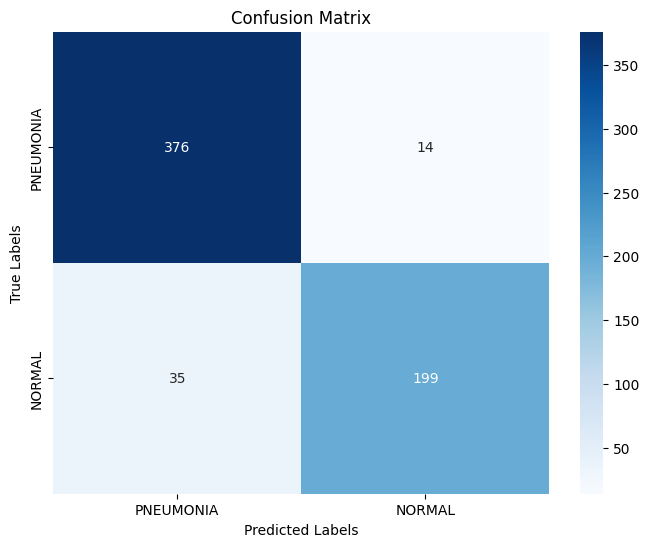

In [23]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assume you have a test DataLoader named 'dataloaders["test"]'
test_dataloader = dataloaders['test']

# Move the model to the evaluation mode
model.eval()

all_preds = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Define class indices for NORMAL and PNEUMONIA
class_indices = {'NORMAL': 1, 'PNEUMONIA': 0}

# Map true labels and predictions to binary values
true_labels_binary = [class_indices[class_names[label]] for label in true_labels]
preds_binary = [class_indices[class_names[label]] for label in all_preds]

# Create confusion matrix
matrix = confusion_matrix(true_labels_binary, preds_binary)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

 A confusion matrix is a table that is often used to evaluate the performance of a classification algorithm. In a binary classification problem, such as identifying PNEUMONIA and NORMAL cases, the confusion matrix has four possible outcomes:

* **True Positive (TP)**: PNEUMONIA cases correctly predicted as PNEUMONIA.
* **True Negative (TN)**: NORMAL cases correctly predicted as NORMAL.
* **False Positive (FP)**: NORMAL cases incorrectly predicted as PNEUMONIA.
* **False Negative (FN**): PNEUMONIA cases incorrectly predicted as NORMAL.


<br/>

Here's an explanation:

- **PNEUMONIA cases (positive class):**
  - **True Positives (TP):** 376
  - **False Negatives (FN):** 35

- **NORMAL cases (negative class):**
  - **True Negatives (TN):** 199
  - **False Positives (FP):** 14

In summary, the model performed well in correctly identifying PNEUMONIA cases (high true positive count), and it correctly identified NORMAL cases as well (high true negative count). However, there were some cases where NORMAL was incorrectly predicted as PNEUMONIA (false positives) and some PNEUMONIA cases were incorrectly predicted as NORMAL (false negatives).

In [26]:
print(classification_report(true_labels_binary, preds_binary))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       390
           1       0.93      0.85      0.89       234

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



- **Precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positives. For class 0 (PNEUMONIA), the precision is 0.91, indicating that 91% of the instances predicted as PNEUMONIA were actually PNEUMONIA. For class 1 (NORMAL), the precision is 0.93, meaning that 93% of the instances predicted as NORMAL were actually NORMAL.

- **Recall (Sensitivity)**: Recall is the ratio of correctly predicted positive observations to the all observations in the actual class. For class 0, the recall is 0.96, indicating that 96% of the actual PNEUMONIA instances were correctly predicted. For class 1, the recall is 0.85, meaning that 85% of the actual NORMAL instances were correctly predicted.

- **F1-Score**: The F1-Score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.94, and for class 1, it is 0.89.

- **Support**: Support is the number of actual occurrences of the class in the specified dataset. For class 0, there are 390 instances, and for class 1, there are 234 instances.

- **Accuracy**: Accuracy is the ratio of correctly predicted instances to the total instances. The overall accuracy is 92%, indicating that 92% of the instances in the dataset were correctly classified.

- **Macro Average and Weighted Average**: These are averages calculated for precision, recall, and F1-score. Macro average calculates the metrics independently for each class and then takes the average, while weighted average accounts for class imbalance.

In summary, the model performs well with high precision, recall, and F1-score for both classes, and the overall accuracy is satisfactory at 92%. The macro and weighted averages suggest a balanced performance across classes.

In [15]:
import os

drive_folder_path = '/content/drive/MyDrive/My Projects/deep learning/dataset/'

model_save_path = os.path.join(drive_folder_path, 'CT_classification_model.pth')

# Save the model state dictionary to the specified path
torch.save(model.state_dict(), model_save_path)



---



# **Classification on Unseen Image**

In [16]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
import torch.nn as nn

drive_folder_path = '/content/drive/MyDrive/My Projects/deep learning/dataset/'

model_load_path = os.path.join(drive_folder_path, 'CT_classification_model.pth')

loaded_model = models.resnet18(pretrained=True)
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 1000)
loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)

new_model.fc.weight.data = loaded_model.fc.weight.data[0:2]
new_model.fc.bias.data = loaded_model.fc.bias.data[0:2]

In [17]:
import torch
from torchvision import transforms
from PIL import Image

image_path = '/content/drive/MyDrive/My Projects/deep learning/dataset/test/PNEUMONIA/BACTERIA-1135262-0002.jpeg'
image = Image.open(image_path)

if image.mode != 'RGB':
    image = image.convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [18]:
with torch.no_grad():
    output = model(input_batch)

_, predicted_class = output.max(1)

class_names = ['NORMAL', 'PNEUMONIA']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: PNEUMONIA


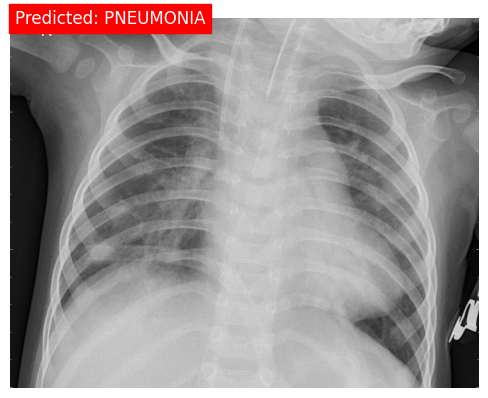

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()